In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


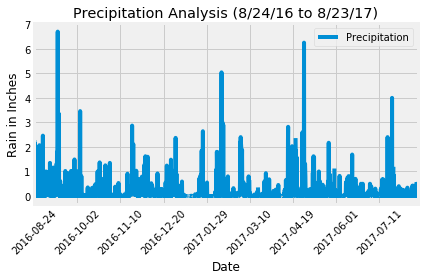

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()

# Sort the dataframe by date
rain_df.set_index('date').head()
clean_rain_df=rain_df.dropna(thresh=1)
clean_rain_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many ("count") stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)? **Descending order
busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"=",count)

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 = 2772
Station USC00519397 = 2724
Station USC00513117 = 2709
Station USC00519523 = 2669
Station USC00516128 = 2612
Station USC00514830 = 2202
Station USC00511918 = 1979
Station USC00517948 = 1372
Station USC00518838 = 511


In [18]:
# Using the station id from the previous query, calculate the lowest & highest temperatures recorded, and average temperature most active station?
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()

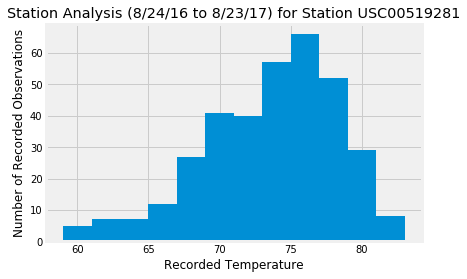

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months ("bins") of temperature observation data for this station and plot the results as a histogram
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)

[(67.0, 74.47368421052632, 82.0)]


Text(0.5, 1.0, 'Trip Avg Temp')

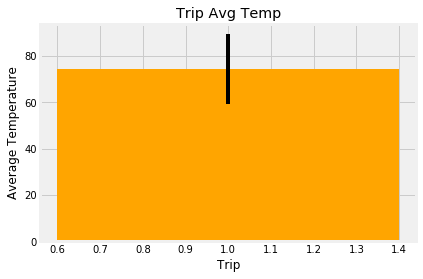

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'orange', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Average Temperature")
ax.set_title("Trip Avg Temp")